In [11]:
#HIDDEN
# Erasmus+ ICCT project (2018-1-SI01-KA203-047081)


import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

%matplotlib notebook

In [12]:
#HIDDEN
h_ = 10 # water level

A = 12000 # area of water tank
Tv = 400 # time discretisation for z-transform

# geometry
x_min = -15
x_max = 60
y_min = -10
y_max = 55
h_tank = 20
l_tank = 37
l_whole_tank = 40
d_pipe = 2
h_ventil = 5
l_ventil = 4
l_pipe1 = 6
l1_pipe2 = 9
l2_pipe2 = 4
l_pipe3 = 6
l_podpore = 5
h_podpore = 4

In [13]:
# lists of points for plot

rob_x = np.array([x_min, x_max, x_max, x_min, x_min])
rob_y = np.array([y_min, y_min, y_max, y_max, y_min])

tank_x = np.array([0, 0, l_whole_tank, l_whole_tank, l_tank, l_tank])
tank_y = np.array([h_tank, 0, 0, d_pipe, d_pipe, h_tank])

ventil_x = np.array([0, l_ventil, l_ventil, 0, 0])
ventil_y = np.array([(h_ventil - d_pipe) / 2, 
                     -(d_pipe + (h_ventil - d_pipe) / 2), (h_ventil - d_pipe) / 2,
                     -(d_pipe + (h_ventil - d_pipe) / 2),
                     (h_ventil - d_pipe) / 2])

pipe1_x = np.array([-l_pipe1, 0, 0, -l_pipe1])
pipe1_y = np.array([0, 0, -d_pipe, -d_pipe])

pipe2_x = np.array([l1_pipe2, l1_pipe2, 0, 0, l1_pipe2 - d_pipe,
                   l1_pipe2 - d_pipe])
pipe2_y = np.array([-l2_pipe2, 0, 0, -d_pipe, -d_pipe, -l2_pipe2])

pipe3_x = np.array([l_pipe3, 0, 0, l_pipe3])
pipe3_y = np.array([0, 0, -d_pipe, -d_pipe])

podpora_x = np.array([-(1/2+1/5)*l_podpore, -1/2*l_podpore, -1/4*l_podpore,
                      -(1/4+1/5)*l_podpore, -1/4*l_podpore, 0, -1/5*l_podpore,
                      0, 1/4*l_podpore, (1/4-1/5)*l_podpore, 1/4*l_podpore,
                      0, -1/4*l_podpore, 1/2*l_podpore, (1/2-1/5)*l_podpore])
podpora_y = np.array([-h_podpore, -3/4*h_podpore, -3/4*h_podpore,
                      -h_podpore, -3/4*h_podpore, -3/4*h_podpore, -h_podpore,
                      -3/4*h_podpore, -3/4*h_podpore, -h_podpore, -3/4*h_podpore,
                      0, -3/4*h_podpore, -3/4*h_podpore, -h_podpore])


<IPython.core.display.Javascript object>


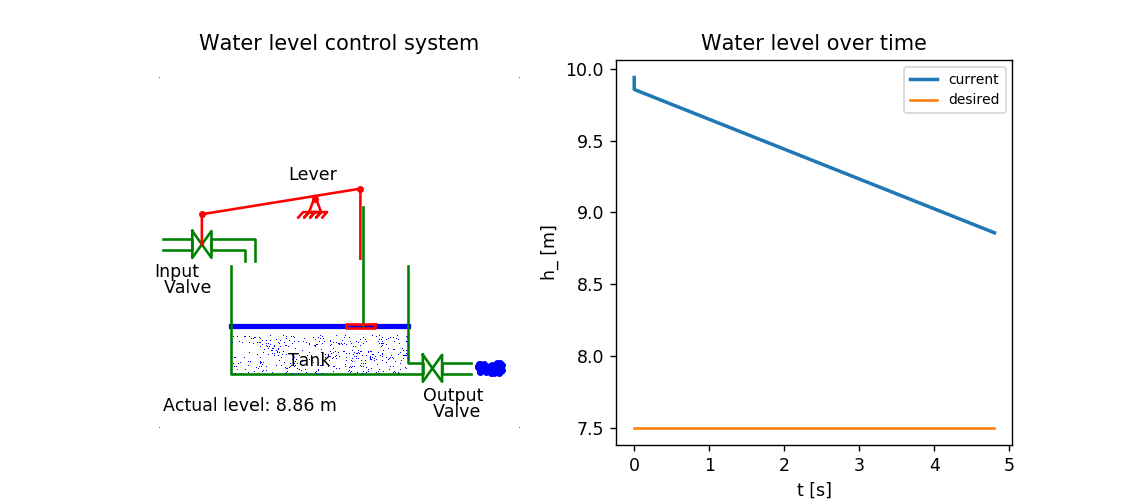

interactive(children=(FloatSlider(value=2.5, description='set_K', max=5.0), FloatSlider(value=7.5, description…

In [14]:
fig = plt.figure(figsize=(9, 4))
ax = fig.add_subplot(1, 2, 1)
ax.set_axis_off()
graph = fig.add_subplot(1, 2, 2)
list_h_x =[]
list_h_y = []
list_h_desired_x = []
list_h_desired_y = []


q_out = 1
q_out_prev = q_out
h_desired =10
h_desired_prev = h_desired
h_ = h_desired
h_prev = h_
K = 1

# interact function
def set_coefficients(set_K, set_h_desired, set_q_out):
    global K, h_desired, q_out
    K = set_K
    h_desired = set_h_desired
    q_out = set_q_out
interact(set_coefficients, set_K=(0., 5., 0.1), set_h_desired=(0, 15.), set_q_out=(0, 5.))

def update_figure(i):
    global h_prev, h_desired_prev, q_out_prev, h_
    
    d = 33 - h_desired
    x = K*(27-(-8 + l_ventil / 2))/(K+1) #za podporo
    
    # functions for calculating new height
    def calculate_new_height(K, h_prev, h_desired, h_desired_prev, q_out, q_out_prev):
        # z-transform (h_)
        temp_result = - h_prev * (K - A * 2 / Tv) + h_desired * K + h_desired_prev * K - q_out - q_out_prev
        return temp_result / (A * 2 / Tv + K)
    def calculate_new_height_negative(h_prev, q_out, q_out_prev):
        # calculated, if desired height is lower than current height
        temp_result = - h_prev * (- A * 2 / Tv) - q_out - q_out_prev
        return temp_result / (A * 2 / Tv)

    if h_desired < h_:
        h_ = calculate_new_height_negative(h_prev, q_out, q_out_prev)
    else:
        h_ = calculate_new_height(K, h_prev, h_desired, h_desired_prev, q_out, q_out_prev)
    
    if (h_<0):
        h_ = 0

    vzvod1_x = np.array([27.5, 27.5])
    vzvod1_y = np.array([h_, h_ + 22])

    vzvod2_x = np.array([27, 27, -8 + l_ventil / 2,
                         -8 + l_ventil / 2])
    vzvod2_y = np.array([h_ + d - 13, h_ + d, -(-33 + (h_ + d)) * K + 33,
                         h_tank + 5 - d_pipe / 2])

    # lists for water drops plot
    koef_in_drops=int((h_desired-h_)*K*5*3)
    if (koef_in_drops<0):
        koef_in_drops = 0
    drops_in_x = np.array([random.randint(-10, 10)/12 for i in range(koef_in_drops)])
    drops_in_y = np.array([random.randint(-10, 10)/2 for i in range(koef_in_drops)])
    
    koef_out_drops = int(q_out*3*5)
    if h_ == 0:
        koef_out_drops = int((h_desired)*K*5*3)
    drops_out_x = np.array([random.randint(-10,10)/4 for i in range(koef_out_drops)])
    drops_out_y = np.array([random.randint(-10, 10)/10 for i in range(koef_out_drops)])

    drops_tank = int(h_)*50
    drops_tank_x = np.array([random.randint(0, 370)/10 for i in range(drops_tank)])
    drops_tank_y = np.array([random.randint(0, int(h_-1)*10)/10 for i in range(drops_tank)])

    plovec_x = np.array([3, 3, -3, -3, 3])
    plovec_y = np.array([0.3, -0.3, -0.3, 0.3, 0.3])
            
    # plot
    ax.clear()
    ax.plot(rob_x, rob_y, ',')
    ax.plot([0, l_tank], [h_, h_], 'b', lw=3)
    ax.plot(tank_x, tank_y, 'g')
    ax.plot(ventil_x + l_whole_tank, ventil_y + d_pipe, 'g')
    ax.plot(pipe1_x - 8, pipe1_y + h_tank + 5, 'g')
    ax.plot(pipe2_x + l_ventil - 8, pipe2_y + h_tank + 5, 'g')
    ax.plot(ventil_x - 8, ventil_y + h_tank + 5, 'g')
    ax.plot(pipe3_x + l_whole_tank + l_ventil, pipe3_y + d_pipe, 'g')
    ax.plot(podpora_x - 8 + l_ventil / 2 + x, podpora_y + 33, 'r')
    ax.plot(vzvod2_x, vzvod2_y, 'r')
    ax.plot(vzvod1_x, vzvod1_y, 'g')
    ax.plot(plovec_x + 27, plovec_y + h_, 'r')
    ax.plot(drops_in_x + l_ventil - 8 + l1_pipe2 - d_pipe / 2, drops_in_y + h_tank + 5 - l2_pipe2 - 7, 'b.')
    ax.plot(drops_out_x + l_whole_tank + l_ventil + l_pipe3 + 4, drops_out_y + d_pipe / 2, 'b.')
    ax.plot(drops_tank_x, drops_tank_y, 'b,')
    ax.plot([27, -8+l_ventil/2, -8+l_ventil/2+x], [h_ + d, -(-33 + (h_ + d))*K + 33, 33-0.5], 'r.')
    
    list_h_x.append(i*Tv/1000)
    list_h_y.append(h_)
    list_h_desired_x.append(i*Tv/1000)
    list_h_desired_y.append(h_desired)
    graph.clear()
    graph.plot(list_h_x, list_h_y, lw=2, label='current')
    graph.plot(list_h_desired_x, list_h_desired_y, label='desired')
    
    ax.set_title('Water level control system')
    ax.text(12, 1.5, 'Tank')
    ax.text(40, -5, 'Output')
    ax.text(42, -8, 'Valve')
    ax.text(-16, 18, 'Input')
    ax.text(-14, 15, 'Valve')
    ax.text(12, 36, 'Lever')
    ax.text(-14, -7, 'Actual level: %.2f m' %h_)
    ax.set_axis_off()
    graph.set_xlabel('t [s]')
    graph.set_ylabel('h_ [m]')
    graph.set_title('Water level over time')
    graph.legend(loc=1, fontsize=8)
    
    h_prev = h_
    h_desired_prev = h_desired
    q_out_prev = q_out 
    
ani = animation.FuncAnimation(fig, update_figure, interval=Tv)
